In [1]:
 import pandas as pd
import numpy as np
import plotly.express as px
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
plt.style.use('ggplot')
from datetime import datetime
import matplotlib.ticker as mtick
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
pd.options.mode.chained_assignment = None

# Проект: вариант 1

# Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Считываем данные:

In [2]:
df_reg = pd.read_csv('problem1-reg_data.csv', sep=';')
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [3]:
df_auth=pd.read_csv('problem1-auth_data.csv', sep=';')
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [4]:
df_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

Переведем timestamp в дату

In [5]:
df_reg["date_reg"] = pd.to_datetime(df_reg["reg_ts"], unit="s")
df_reg=df_reg[['uid', 'date_reg']]
df_auth["date_auth"] = pd.to_datetime(df_auth["auth_ts"], unit="s")
df_auth=df_auth[['uid', 'date_auth']]

Соединим 2 датасета

In [6]:
df=df_reg.merge(df_auth, on='uid')
df=df[['uid', 'date_reg', 'date_auth']]
df

,uid,date_reg,date_auth
0,1,1998-11-18 09:43:43,1998-11-18 09:43:43
1,2,1999-07-22 22:38:09,1999-07-22 22:38:09
2,2,1999-07-22 22:38:09,1999-07-25 16:46:46
3,2,1999-07-22 22:38:09,1999-07-31 03:50:15
4,2,1999-07-22 22:38:09,1999-08-05 17:49:39
...,...,...,...
9601008,1110618,2020-09-23 15:13:54,2020-09-23 15:13:54
9601009,1110619,2020-09-23 15:14:46,2020-09-23 15:14:46
9601010,1110620,2020-09-23 15:15:39,2020-09-23 15:15:39
9601011,1110621,2020-09-23 15:16:31,2020-09-23 15:16:31


Преобразуем столбцы с датами, чтобы удалить время

In [7]:
df.date_reg=df.date_reg.astype('str')
df.date_auth=df.date_auth.astype('str')

In [8]:
df.date_auth = df.date_auth.apply(lambda x: x[:10])
df.date_auth = pd.to_datetime(df.date_auth, format='%Y-%m-%d')
df.date_reg = df.date_reg.apply(lambda x: x[:10])
df.date_reg = pd.to_datetime(df.date_reg, format='%Y-%m-%d')

In [9]:
df.head()

,uid,date_reg,date_auth
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05


Посмотрим на самую раннюю и позднюю даты

In [10]:
df.date_reg.max()

Timestamp('2020-09-23 00:00:00')

In [11]:
df.date_reg.min()

Timestamp('1998-11-18 00:00:00')

Напишем функцию для построения retention matrix

In [12]:
def retention_function(data, start_date, end_date):
    dataset = df.query("date_reg >= @start_date and date_auth <= @end_date")
    dataset['player_lifetime'] = dataset.date_auth - dataset.date_reg
    
    retention_pivot = dataset.pivot_table(index='date_reg', columns='player_lifetime', values='uid', aggfunc = 'nunique')
    retention_pivot=retention_pivot.divide(retention_pivot.iloc[:, 0], axis='index')
    
    retention_pivot.index=retention_pivot.index.strftime('%d %b %Y')
    
    plt.figure(figsize=(21, 10))
    visual = sns.heatmap(retention_pivot, annot=True, cmap='Greens', fmt='.0%', vmax=0.1, xticklabels = retention_pivot.columns.astype('str'), yticklabels = retention_pivot.index.astype('str'), annot_kws={"fontsize":14})
    visual.set_title(f'''Retention for {dataset['player_lifetime'].max().days} days''', fontsize=30) 
    
    return retention_pivot

player_lifetime,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,22 days,23 days,24 days,25 days,26 days,27 days,28 days,29 days,30 days,31 days
date_reg,,,,,,,,,,,,,,,,,,,,,
10 Oct 2019,1.0,0.016199,0.035637,0.036717,0.037797,0.050756,0.063715,0.051836,0.035637,0.037797,...,0.039957,0.026998,0.029158,0.029158,0.024838,0.034557,0.029158,0.017279,0.019438,0.030238
11 Oct 2019,1.0,0.018319,0.052802,0.045259,0.044181,0.071121,0.075431,0.070043,0.050647,0.047414,...,0.039871,0.042026,0.043103,0.030172,0.045259,0.028017,0.036638,0.035560,0.029095,NaN
12 Oct 2019,1.0,0.017223,0.050592,0.031216,0.043057,0.060280,0.055974,0.052745,0.057051,0.060280,...,0.043057,0.040904,0.041981,0.040904,0.029064,0.025834,0.026911,0.033369,NaN,NaN
13 Oct 2019,1.0,0.019334,0.044039,0.036520,0.042965,0.058002,0.067669,0.058002,0.034372,0.049409,...,0.046187,0.033298,0.026853,0.025779,0.033298,0.027927,0.023631,NaN,NaN,NaN
14 Oct 2019,1.0,0.018240,0.039700,0.033262,0.066524,0.052575,0.060086,0.050429,0.038627,0.049356,...,0.024678,0.040773,0.031116,0.036481,0.026824,0.035408,NaN,NaN,NaN,NaN
15 Oct 2019,1.0,0.022484,0.042827,0.038544,0.052463,0.063169,0.062099,0.046039,0.048180,0.044968,...,0.033191,0.032120,0.033191,0.026767,0.032120,NaN,NaN,NaN,NaN,NaN
16 Oct 2019,1.0,0.027807,0.024599,0.039572,0.040642,0.050267,0.056684,0.052406,0.052406,0.043850,...,0.033155,0.026738,0.031016,0.029947,NaN,NaN,NaN,NaN,NaN,NaN
17 Oct 2019,1.0,0.014941,0.040555,0.041622,0.040555,0.055496,0.078975,0.055496,0.041622,0.042689,...,0.044824,0.034152,0.030950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18 Oct 2019,1.0,0.031983,0.039446,0.052239,0.057569,0.059701,0.065032,0.047974,0.055437,0.057569,...,0.036247,0.034115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


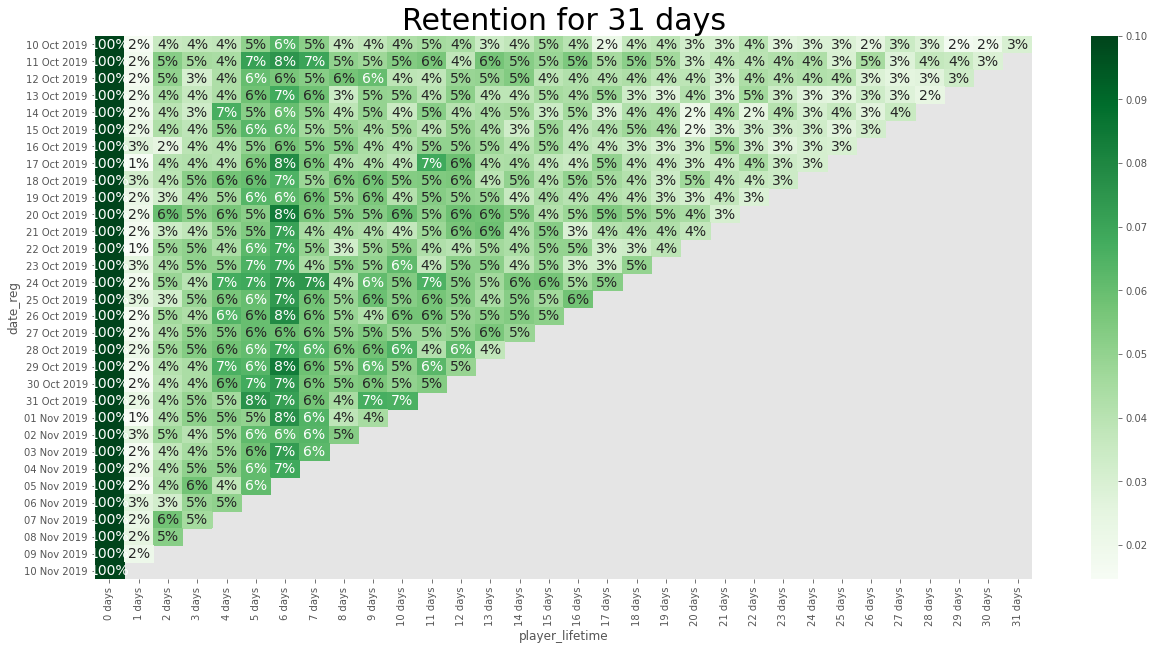

In [13]:
retention_function(df, start_date="2019-10-10", end_date="2019-11-10")

# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [14]:
df=pd.read_csv('Проект_1_Задание_2.csv', sep=';')
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Посмотрим на метрики для анализа

# Конверсия

In [15]:
df_a = df.query('testgroup=="a"')
df_b = df.query('testgroup=="b"')

In [16]:
pay_a=df_a.query('revenue> 0')
pay_b=df_b.query('revenue> 0')

In [17]:
cr_a = round(pay_a.shape[0]/df_a.shape[0]*100, 2)
cr_a

0.95

In [18]:
cr_b = round(pay_b.shape[0]/df_b.shape[0]*100, 2)
cr_b

0.89

# Средний чек

In [19]:
mean_rev_a = pay_a.revenue.mean().round(2)
mean_rev_a

2664.0

In [20]:
mean_rev_b = pay_b.revenue.mean().round(2)
mean_rev_b

3003.66

# Медианный чек

In [21]:
median_rev_a=pay_a.revenue.median()
median_rev_a

311.0

In [22]:
median_rev_b=pay_b.revenue.median()
median_rev_b

3022.0

# Максимальный  и минимальный чеки

In [23]:
pay_a.revenue.min()

200

In [24]:
pay_a.revenue.max()

37433

In [25]:
pay_b.revenue.min()

2000

In [26]:
pay_b.revenue.max()

4000

# ARPU

In [28]:
rev_sum_a = pay_a.revenue.sum()
rev_sum_a

5136189

In [29]:
arpu_a =round(rev_sum_a/df_a.shape[0],2)
arpu_a

25.41

In [30]:
rev_sum_b = pay_b.revenue.sum()
rev_sum_b

5421603

In [31]:
arpu_b =round(rev_sum_b/df_b.shape[0],2)
arpu_b

26.75

# ARPPU

In [32]:
arppu_a=round(rev_sum_a/pay_a.shape[0], 2)
arppu_a

2664.0

In [33]:
arppu_b=round(rev_sum_b/pay_b.shape[0], 2)
arppu_b

3003.66

# Повторные покупки

In [41]:
df_a.user_id.nunique()-df_a.shape[0]

0

In [40]:
df_b.user_id.nunique()-df_b.shape[0]

0

In [38]:
#Повторных покупок нет, каждый id уникальный

Можно сделать табличку для удобства

In [39]:
metrics_df = pd.DataFrame({'users_number' : [df_a.shape[0], df_b.shape[0]],
                          'pay_users' : [pay_a.shape[0], pay_b.shape[0]],
                          'cr':[cr_a, cr_b],
                          'avg_check':[mean_rev_a, mean_rev_b],
                          'min_check':[pay_a.revenue.min(), pay_b.revenue.min()],
                          'max_check':[pay_a.revenue.max(), pay_b.revenue.max()],
                          'median_check':[median_rev_a, median_rev_b],
                          'arppu':[arppu_a, arppu_b],
                          'arpu':[arpu_a, arpu_b],
                         'total_rev':[rev_sum_a, rev_sum_b]},
                         index=['a_group', 'b_group'])
metrics_df

,users_number,pay_users,cr,avg_check,min_check,max_check,median_check,arppu,arpu,total_rev
a_group,202103,1928,0.95,2664.00,200,37433,311.0,2664.00,25.41,5136189
b_group,202667,1805,0.89,3003.66,2000,4000,3022.0,3003.66,26.75,5421603


# Можно переходить к статистическому анализу. Посмотрим на нормальность распределения.

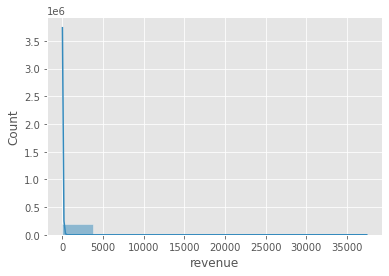

In [42]:
#группа a
sns.histplot(df_a.revenue, kde = True, bins=10)

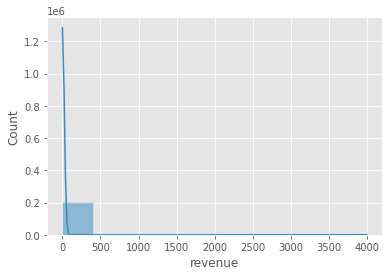

In [43]:
#Группа b
sns.histplot(df_b.revenue, kde = True, bins=10)

In [44]:
stats.shapiro(df_a.revenue.sample(1000, random_state=15))

ShapiroResult(statistic=0.01335233449935913, pvalue=0.0)

In [45]:
stats.shapiro(df.revenue.sample(1000, random_state=15))

ShapiroResult(statistic=0.027711689472198486, pvalue=0.0)

Видно, что распределение выборок ненормальное, для анализа нужно применить метод bootstrap

Гипотезы:

Н0 - разница в средних значениях в обоих группах отсутствует (при p > 0.05)

Н1 - разница есть (при p < 0.05)

In [46]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value}

Посмотрим на данные о revenue от всех user_id

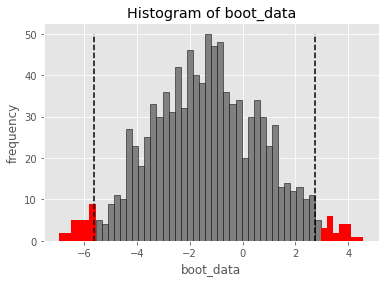

{'p_value': 0.5194640039037319}

In [47]:
get_bootstrap(df_a.revenue, df_b.revenue)

In [48]:
round(0.5194640039037319, 2)

0.52

Посмотрим на данные о revenue от всех платящих пользователей

Гипотезы:

Н0 - разница в средних значениях в обоих группах отсутствует (при p > 0.05)

Н1 - разница есть (при p < 0.05)

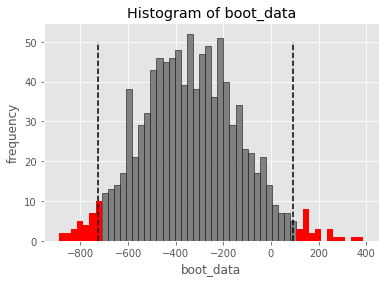

{'p_value': 0.10719802723408547}

In [50]:
get_bootstrap(pay_a.revenue, pay_b.revenue)

In [51]:
round(0.10719802723408547, 2)

0.11

По результатам анализа становится понятно, что p-value > 0.05 и 0 входит в доверительный интервал, значит, мы не можем отклонить нулевую гипотезу о том, что статистически значимых различий нет. Подтверждаем гипотезу о равенстве средних.


Из анализа метрик видно, разницы между  средней прибылью тестовой и контрольной групп нет, однако есть различия в объемах минимальных и максимальных платежей. Также есть разница в количестве пользователей, совершающих покупки.

В общем, акционные предложения не принесли значительного финансового результата, рекомендация для компании была бы развивать маркетинговые стратегии для увеличения среднего чека, также можно ввести систему подписок, так каждый пользователь вносил плату, ведь по датафрейму видно, что большинство ничего не заплатило.

# Задание 3

Renention - позволит посмотреть, сколько пользователей закончили/не закончили игру.

MAU и DAU - позволит посмотреть на количество игроков в день/месяц.

ARPU, ARPPU - позволит определить окупаемость затрат и покажет нужно ли усовершенствовать привлечение пользователей/алгоритмы игры .

CR - позволит оценить вовлеченность игроков, например в зависимости от сезонных событий.

Если усложнить игру, то нужно будет мотреть на Retention, CR и на то сколько игроков прекратило возвращаться в игру после неудачных попыток или они реже будут заходить в игру (DAU, MAU). Возможно, неудачные попытки отобьют желание, как следствие отток игроков уменьшит прибыль и ARPU и ARPPU.